# Imports and Variables

In [ ]:
import os
import numpy as np
import random
import torch


from torch.utils.data import DataLoader
from torchvision import transforms

from caps_cropped_model import CapsuleNetwork, CapsuleLoss
from caps_utils import DICOMCoarseDataset, display_data_loader_batch, TransformDataset

In [ ]:
BASE_DIR_TEST = "D:/Datasets/YOLO_Caps/test"
seed = 41
batch_size = 16
classes = ["cropped_nodule", "cropped_non_nodule"]
image_size = 128


random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Model

In [ ]:
# Define CapsNet 
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)


In [ ]:
# Load weights of trained model
checkpoint = torch.load("CAPS_CROPPED/weights/caps_crop_new.pt")
model_state_dict = checkpoint['model_state_dict']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

capsule_net.load_state_dict(model_state_dict)
capsule_net.eval()
capsule_net.to(device)

print(capsule_net)

C:\Users\chris\AppData\Local\Temp\ipykernel_12736\640331367.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("CAPS_CROPPED/weights/caps_crop_new.p

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=16384, bias=True)
      (5): Sigmoid()
    )
  )
)


# Dataset

## Load Dataset

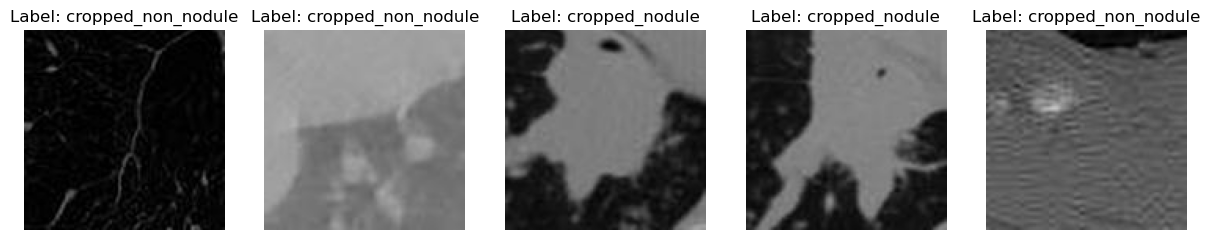

In [ ]:
test_dataset = DICOMCoarseDataset(root_dir=BASE_DIR_TEST, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_TEST, "nodule"))), classes=classes)
test_dataset.visualize_images(num_images=5)

In [7]:
test_dataset[0]

(<PIL.Image.Image image mode=RGB size=128x128>, 0)

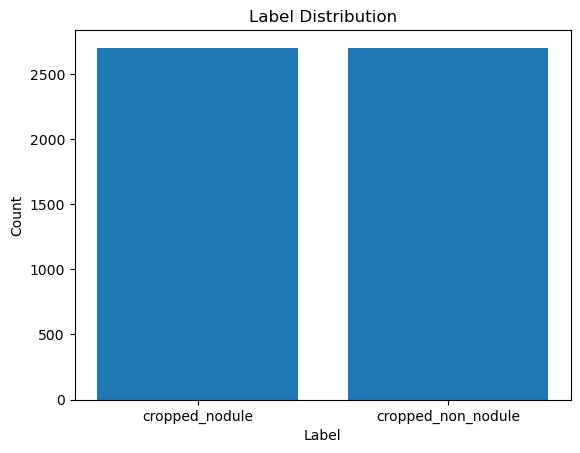

In [8]:
test_dataset.display_label_distribution()

## Dataset Augmentation

In [ ]:
# Only dataset preperation no Augmentation 
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

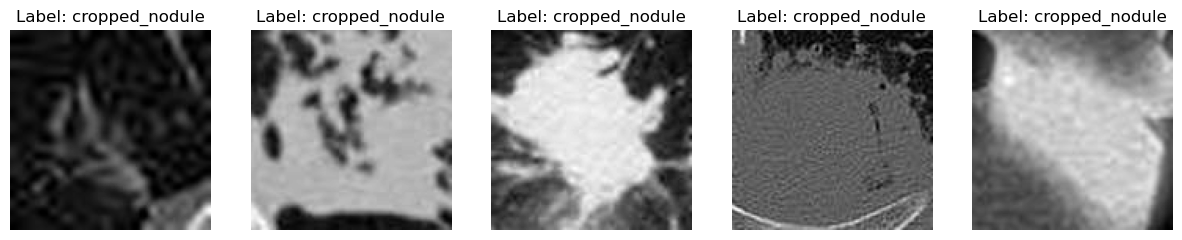

In [ ]:
# transform dataset
test_dataset = TransformDataset(test_dataset, transform=transform)
# create dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# visualize images of a batch
display_data_loader_batch(test_loader, classes)

# Results

Test Loss: 2.50209138

Test Accuracy of     0: 94.67% (2556/2700)
Test Accuracy of     1: 96.48% (2605/2700)

Test Accuracy (Overall): 95.57% (5161/5400)


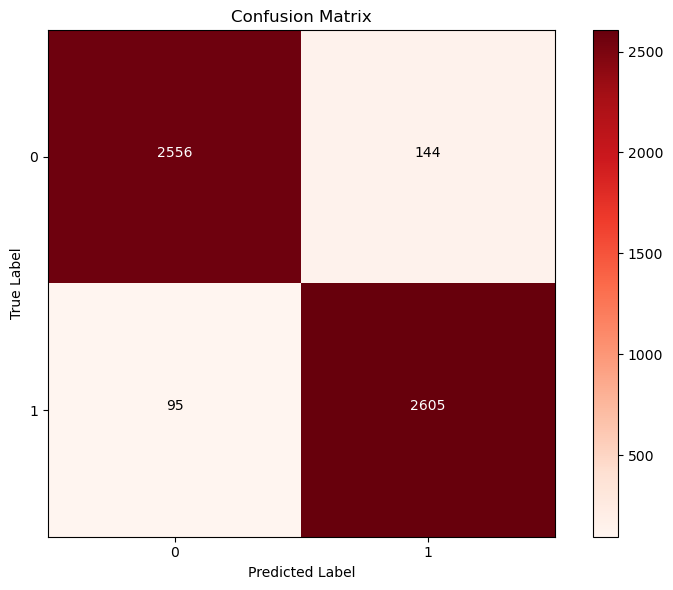

In [ ]:
# Define Loss
criterion = CapsuleLoss()
# Run test
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

In [ ]:
# Results of the Confusion Matrix + Metrics
tp=2556
tn=2605
fp=95
fn=144

accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Ergebnisse ausgeben
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

True Positives (TP): 2556
False Positives (FP): 95
True Negatives (TN): 2605
False Negatives (FN): 144
Accuracy: 0.9557
Precision: 0.9642
Recall: 0.9467
F1-Score: 0.9553
